In [0]:
import tensorflow as tf
import numpy as np


In [0]:
def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    # Create samples for each cluster
    for i in range(n_clusters):
        samples = tf.random_normal((n_samples_per_cluster, n_features),
                                   mean=0.0, stddev=5.0, dtype=tf.float32, seed=seed, name="cluster_{}".format(i))
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor/2)
        centroids.append(current_centroid)
        samples += current_centroid
        slices.append(samples)
    # Create a big "samples" dataset
    samples = tf.concat(slices, 0, name='samples')
    centroids = tf.concat(centroids, 0, name='centroids')
    return centroids, samples


In [0]:
def plot_clusters(all_samples, centroids, n_samples_per_cluster):
    import matplotlib.pyplot as plt
    # Plot out the different clusters
    # Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0, 1, len(centroids)))

    for i, centroid in enumerate(centroids):
        # Grab just the samples fpr the given cluster and plot them out with a new colour
        samples = all_samples[i * n_samples_per_cluster:(i + 1) * n_samples_per_cluster]
        plt.scatter(samples[:, 0], samples[:, 1], c=colour[i])
        # Also plot centroid
        plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color='m', mew=5)
    plt.show()


In [0]:
def choose_random_centroids(samples, n_clusters):
    # Step 0: Initialisation: Select `n_clusters` number of random points
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    begin = [0,]
    size = [n_clusters,]
    size[0] = n_clusters
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids


In [0]:
def assign_to_nearest(samples, centroids):
    # Finds the nearest centroid for each sample

    # START from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum( tf.square(
               tf.subtract(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    # END from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    nearest_indices = mins
    return nearest_indices

In [0]:
def update_centroids(samples, nearest_indices, n_clusters):
    # Updates the centroid to be the mean of all samples associated with it.
    nearest_indices = tf.to_int32(nearest_indices)
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions], 0)
    return new_centroids

In [0]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

np.random.seed(seed)

In [8]:
data_centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)
nearest_indices = assign_to_nearest(samples, initial_centroids)
updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    updated_centroid_value = session.run(updated_centroids)
    print(updated_centroid_value)

[[-28.005798    -2.6411068 ]
 [-17.876902    -0.26788092]
 [-24.24279     23.149775  ]]


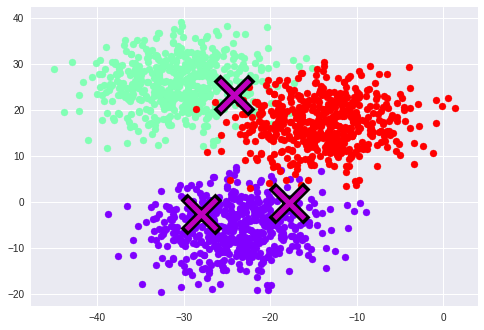

In [9]:
plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)